# RNN

RNN은 시계열 데이터를 다루기 위한 신경망입니다.  
Recurrent Neural Network라는 용어명에서도 알 수 있듯이 "순환"하는 경로가 존재하여 데이터가 순환됩니다.  
즉, 과거의 정보를 "기억"하는 동시에 이에 새로운 정보를 추가해 "갱신"하게 됩니다.

## RNN Layer의 Forward propagation

# $$\mathbf{h_t} = \text{tanh}(\mathbf{h_{t-1}W_h + x_tW_x+b})$$

RNN Layer 또한 데이터를 Mini-Batch로 처리합니다. 따라서 $\mathbf{x_t}$와 $\mathbf{h_t}$에 각 샘플 데이터를 행 방향으로 묶어 처리합니다.  
따라서 아래와 같은 shape을 가지게 됩니다.

# $\begin{array}{lcl}
\mathbf{h_{t-1}} & = & N \times H \\
\mathbf{W_h} & = & H \times H \\
\mathbf{x_{t}} & = & N \times D \\
\mathbf{W_x} & = & D \times H \\
\mathbf{b_t} & = & N \times H \\
\end{array}$

---

# RNN 구현

In [1]:
class RNN:
    def __init__(self, Wx, Wh, b):
        '''
        NN의 weight를 초기화하고, backward를 위한 grad와 forward값을 인스턴스 변수로 저장해두는 부분입니다.
        '''
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)] # gradient 저장
        self.cache = None

    def forward(self, x, h_prev):
        '''
        input 값으로 아래 두 가지를 받습니다.
        x : 현재 시점 t에서의 입력 (하나의 단어)
        h_prev : 이전 시점 t-1에서의 hidden state
        '''
        Wx, Wh, b = self.params
        t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b
        h_next = np.tanh(t) # 현시점의 출력(다음 시각 t+1로의 입력)

        self.cache = (x, h_prev, h_next) # backward를 위해 forward시의 값을 저장해둡니다.
        return h_next

    def backward(self, dh_next):
        '''
        dh_next : 다음 시각 t+1로부터 내려온 gradient
        아래의 backward graph를 참고
        '''
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache # forward 시의 입출력값 저장해 놓은 것 가져옴

        dt = dh_next * (1 - h_next ** 2) # (N x H) 빨간색 (tanh -> +)
        db = np.sum(dt, axis=0)    # (N x H) ==> (1 x H)
        dWh = np.dot(h_prev.T, dt) # (H x N) @ (N x H) ==> (H x H)
        dh_prev = np.dot(dt, Wh.T) # (N x H) @ (H x H) ==> (N x H)
        dWx = np.dot(x.T, dt)      # (D x N) @ (N x H) ==> (D x H) 
        dx = np.dot(dt, Wx.T)      # (N x H) @ (H x D) ==> (N x D) 임베딩 벡터 학습시킬 때 필요

        self.grads[0][...] = dWx # cf. [...] : deep copy : 별도의 메모리 주소를 할당
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        return dx, dh_prev

<img src="rnn_backprop.png">

# Time RNN Layer 구현
- T개의 RNN 계층으로 구성된 RNN Layer을 만듭니다.  
- 즉, 시계열 데이터 길이가 T인 Truncated BPTT를 하기위한 Layer입니다.

<img src="rnn_timernn.png">

Backpropagation은 다음과 같이 이뤄집니다.  
output layer에서 내려오는 기울기를 dhs, 아래로 내보내는 기울기를 dxs라 표기합니다.  
Truncated BPTT이므로 dh는 필요하지 않습니다. 그러나 뒤에 다룰 seq2seq 모델에서 사용하므로 만들어둡니다.  
h는 여기선 영벡터입니다. 최초 RNN layer에 대한 이전 상태의 hidden state로 넣어주는 값입니다.  

<img src="rnn_timernn_back.png">

t번쨰 RNN에서의 backpropgation시 $\mathbf{dh_t}$와 $\mathbf{dh_{next}}$가 합산되어 전해집니다.

<img src="rnn_timernn_backprop_at_t.png">

In [2]:
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        '''
        NN의 weight를 초기화하고
        forward를 위한 hidden state h와
        backward를 위한 grad와 forward, 그리고 dh값을 인스턴스 변수로 저장해두는 부분입니다.
        '''
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        # forward() 메서드 호출시 h는 마지막 RNN hidden state를 저장하고
        # backward() 메서드 호출시 dh는 한 시점 앞 블록의 hiddenstate의 gradient를 저장합니다(위에서 내려오는 기울기)
        self.h, self.dh = None, None
        
        # 한 번의 Backward연산이 끝나고 새로운 데이터를 받을 때 이전의 hidden state를 유지할 것인지를 정합니다.
        # 전체 데이터가 하나로 쭉 이어진 시계열 데이터라면 유지해야 합니다.
        self.stateful = stateful

    def forward(self, xs):
        '''
        input 값으로 Batch size = N, ""시간축 길이 = T"", embedding dimension = D 인 데이터를 받습니다. 
        N x T x D (3차원)
        '''
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape

        # 각 시점에서의 RNN layer를 self.layers 리스트에 저장합니다.
        # hs : 각 시점에서의 hidden state를 저장해두기 tensor입니다.
        self.layers = []
        hs = np.empty((N, T, H), dtype='f')
        
        '''
        self.stateful이 False 즉, hidden state를 유지하지 않기로 설정했거나,
        self.h가 False, 즉 최초 실행시에는 self.h를 영벡터로 초기화합니다.
        RNN이 이전 시점의 hidden state를 입력으로 받는데, 최초 실행시는 이전 hidden state가 없기 때문에
        영벡터를 입력으로 넣어줍니다.
        '''
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')

        # 시간축 길이 T만큼 for문을 돌면서 
        for t in range(T):
            layer = RNN(*self.params) # RNN layer를 생성하고
            self.h = layer.forward(xs[:, t, :], self.h) # 시점 t의 데이터 x_t와 h_(t-1)을 입력해 forward한 뒤
            # xs: 현재 시점, self.h = h(t-1)
            hs[:, t, :] = self.h   # hidden state를 t시점의 위치에 저장하고
            self.layers.append(layer) # 해당 layer를 리스트에 저장합니다(backward시 필요)
            
        return hs

    def backward(self, dhs):
        '''
        dhs : output layer 쪽에서 전해지는 기울기
        '''
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape
        
        '''
        dxs : 아래로 내보내는 gradient를 담을 빈 Tensor
        dh : seq2seq 모델을 위해서 저장해두는 hidden state
        grads : 각각 Wx, Wh, b에 대한 gradient가 저장된다.
                이 때, 각 시점의 RNN layer들은 모두 동일한 weights를 공유하므로
                 backward시에 각 시점의 gradient가 모두 합산된다.
        '''
        dxs = np.empty((N, T, D), dtype='f')
        dh = 0   # dh_next(이전 시점의 hidden state의 gradient)를 의미
                 # backward시 가장 마지막 RNN layer의 dh_next는 없으므로 0
        grads = [0, 0, 0]
        for t in reversed(range(T)): # forward와는 달리 거꾸로 for문을 수행
            layer = self.layers[t]   # forward시 저장한 layer를 가져와서
            dx, dh = layer.backward(dhs[:, t, :] + dh) # outputlayer의 t시점에서 내려온 gradient인 dh_t와 dh_next를 더하여 backward
            # 현재 시점과 이전 시점의 gradient 더한다
            dxs[:, t, :] = dx  # 아래로 내보낼 t시점의 gradient dxs_t를 저장함

            for i, grad in enumerate(layer.grads): # 현재 backward하는 layer의 Wx, Wh b에 대한 gradients를 누적합 
                grads[i] += grad # weight를 공유하기 때문에 누적합 gradient들이 다시 W로 다 더해짐
                
        # backward가 모두 끝나면 Wx, Wh, b에 대한 gradients를 인스턴스 변수에 저장
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh # 최종 hidden state의 gradients를 저장해둠(for seq2seq)

        return dxs

    # hidden state를 임의의 값으로 설정하거나 초기화하기 위한 메서드
    def set_state(self, h):
        self.h = h

    def reset_state(self):
        self.h = None


# 2. RNN Language Model(RNNLM)

RNN을 사용해서 Languge Model을 구현합니다.  
먼저 RNNLM의 신경망 구조는 아래와 같습니다.  
왼쪽은 Layer 구성이고, 오른쪽은 시간축으로 펼친 그림입니다.

<img src="RNNLM.png">

W_t 는 t시점에서의 단어(또는 token)입니다.  
가장 아래에 **Embedding layer**를 볼 수 있는데, NLP Basic에서 배웠던 word2vec 모델이 전체 모델에 포함된 것이라 할 수 있습니다. 입력 단어의 one hot encoding과 weight($\mathbf{W_E}$)를 dot product하여
나온 값을 해당 단어의 embedding값으로 사용합니다.  
예를 들면 단어 "dog"이 전체 단어목록 V에서 3번째 단어이고 전체 단어(V)가 100개이면,  
embedding layer의 weight($\mathbf{W_E}$)는 (100 x D)이고, (D는 embedding dimension)  
"dog"의 W_t는 [0, 0, 1, ..., 0, 0]으로 표현됩니다. 이를 embedding weight와 dot product한 결과는 embedding weight의 3번째 행을 뽑아낸 결과가 됩니다. 즉 해당 단어의 word embedding 값입니다.  
embedding weight는 이전에 word embedding한 값을 불러와 사용할 수 있으며, 또는 지금처럼 random으로 초기화한 후 모델의 학습이 진행됨에 따라 적절한 word embedding값을 얻을 수도 있습니다.



다음으로 **RNN layer**를 지나, **Affine layer**를 거쳐 **Softmax layer**를 통과합니다.
**Softmax layer**를 통과한 결과는 각 시점(t)에서 예측한 다음 시점(t+1)에 올 단어의 확률 분포입니다.  
여기서 **Affine layer**는 우리가 MLP에서 봤었던 Activation function에 통과하기 이전의 선형변환을 말합니다.

그런데 모델이 학습을 하려면 Loss function이 있어야 합니다. 위의 그림에 Loss function을 추가하면 아래 그림과 같습니다.  
각 시점에서의 Loss를 모두 계산하여 이를 평균한 값을 Loss로 취합니다.

<img src="RNNLM_loss.png">

## RNNLM CODE

In [3]:
import sys
sys.path.append('..')
import numpy as np
from common.time_layers import *


class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn #메서드를 짧게 표현

        # 가중치 초기화(Xavior)
        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W), # 시간길이 T인 입력데이터에 대해 Embedding layer를 한 번에 처리하는 layer
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True), # 시간길이 T인 입력데이터에 대한 RNN(Truncated RNN)
            TimeAffine(affine_W, affine_b) # 시간길이 T인 입력데이터에 대해 Affine 변환을 한 번에 처리하는 Layer
        ]
        self.loss_layer = TimeSoftmaxWithLoss() # 시간길이 T인 입력데이터에 대해 Softmax cross entropy loss를 한 번에 계산하는 layer
        self.rnn_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.rnn_layer.reset_state()


## RNNLM Training & Evaluation

### Langube Model의 평가
- **perplexity**
- 쉽게 말해 확률의 역수로, 다음에 등장할 수 있는 단어의 분기수. 즉 다음에 가능한 단어의 후보 수
- 좋은 모델일 수록 다음에 등장할 단어를 높은 확률로 예측한다.  
예를 들어 "You say goodbye and I say hello"라는 copurs로 학습했을 때,
  "You" 다음에 올 단어로 "say"를 0.8의 확률로 예측했다면 perplexity는 1/0.8 = 1.25 가 되며 0.5의 확률로 예측했다면 perplexity = 1/0.5 = 2.5가 된다.  
- perplexity가 낮을 수록 좋은 모델
- 다음에 가능한 후보의 수를 많이 좁힐 수록 모델의 성능이 좋다.

# $$ L = - \frac{1}{N}\sum_{n}\sum_{k}t_{nk}\text{log}y_{nk} $$
# $$ \mathbf{perplexity} = e^L $$ 

$L$은 softmax with crossentropy loss를 의미함. 다음 단어를 하나의 단어로 특정지을수록 Loss가 줄어들고, perplexity 또한 줄어든다.

In [4]:
# coding: utf-8
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from dataset import ptb
from simple_rnnlm import SimpleRnnlm


# 하이퍼파라미터 설정
batch_size = 10
wordvec_size = 100
hidden_size = 100 # RNN의 은닉 상태 벡터의 원소 수
time_size = 5     # Truncated BPTT가 한 번에 펼치는 시간 크기
lr = 0.1
max_epoch = 100

# 학습 데이터 읽기(전체 중 1000개만)
corpus, word_to_id, id_to_word = ptb.load_data('train') # 단어에 대한 사전
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]  # 입력 (0 - 999)
ts = corpus[1:]   # 출력(정답 레이블) (1 - 1000)
data_size = len(xs)
print('말뭉치 크기: %d, 어휘 수: %d' % (corpus_size, vocab_size))

# 학습 시 사용하는 변수
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# 미니배치의 각 샘플의 읽기 시작 위치를 계산
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)] # 잘랐을 때 시작되는 위치
#

# Truncated BPTT
for epoch in range(max_epoch):
    for iter in range(max_iters):
        # 미니배치 취득
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        # 기울기를 구하여 매개변수 갱신
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # 에폭마다 퍼플렉서티 평가
    ppl = np.exp(total_loss / loss_count)
    print('| 에폭 %d | 퍼플렉서티 %.2f'
          % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0


말뭉치 크기: 1000, 어휘 수: 418
| 에폭 1 | 퍼플렉서티 379.33
| 에폭 2 | 퍼플렉서티 256.43
| 에폭 3 | 퍼플렉서티 221.32
| 에폭 4 | 퍼플렉서티 212.03
| 에폭 5 | 퍼플렉서티 204.15
| 에폭 6 | 퍼플렉서티 201.58
| 에폭 7 | 퍼플렉서티 197.23
| 에폭 8 | 퍼플렉서티 195.03
| 에폭 9 | 퍼플렉서티 190.10
| 에폭 10 | 퍼플렉서티 191.48
| 에폭 11 | 퍼플렉서티 188.33
| 에폭 12 | 퍼플렉서티 191.53
| 에폭 13 | 퍼플렉서티 190.00
| 에폭 14 | 퍼플렉서티 189.61
| 에폭 15 | 퍼플렉서티 188.98
| 에폭 16 | 퍼플렉서티 186.15
| 에폭 17 | 퍼플렉서티 182.70
| 에폭 18 | 퍼플렉서티 179.92
| 에폭 19 | 퍼플렉서티 180.67
| 에폭 20 | 퍼플렉서티 182.25
| 에폭 21 | 퍼플렉서티 180.85
| 에폭 22 | 퍼플렉서티 178.06
| 에폭 23 | 퍼플렉서티 175.45
| 에폭 24 | 퍼플렉서티 174.71
| 에폭 25 | 퍼플렉서티 174.26
| 에폭 26 | 퍼플렉서티 172.35
| 에폭 27 | 퍼플렉서티 168.42
| 에폭 28 | 퍼플렉서티 167.49
| 에폭 29 | 퍼플렉서티 164.68
| 에폭 30 | 퍼플렉서티 160.32
| 에폭 31 | 퍼플렉서티 160.23
| 에폭 32 | 퍼플렉서티 153.94
| 에폭 33 | 퍼플렉서티 155.34
| 에폭 34 | 퍼플렉서티 148.11
| 에폭 35 | 퍼플렉서티 147.33
| 에폭 36 | 퍼플렉서티 140.65
| 에폭 37 | 퍼플렉서티 137.97
| 에폭 38 | 퍼플렉서티 133.90
| 에폭 39 | 퍼플렉서티 128.77
| 에폭 40 | 퍼플렉서티 123.52
| 에폭 41 | 퍼플렉서티 122.62
| 에폭 42 | 퍼플렉서티 117.01
| 에폭 43 | 퍼플렉서티 111

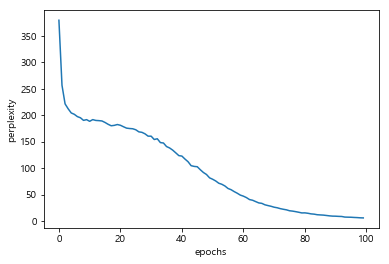

In [5]:
# 그래프 그리기
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()